In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Read Data

In [2]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                print('\t',key1,'\t',len(val1))

In [3]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'YEL' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(agnIDs_dict)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, IRAC, and 24um (n=352). Row 2 = MIR-X-ray inclusive AGN with id, redshift, IRAC, and 24um (n=548). Row 3 = X-ray exclusive AGN with id, redshift, IRAC, and 24um (n=1227). ']
RED 	 352
YEL 	 548
BLU 	 1227


In [4]:
# get redshifts
zDict = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')
zDict_le = adp.GetRedshifts_lessEq(zMax=1,zDict=zDict)

Cropped:  ['ID', 'z']
Number of redshifts: 485793
Number of redshifts <=1: 211361


In [5]:
agnInfo = {}
for key,val in agnIDs_dict.items():
    # match redshift to AGN
    key_zid, key_idz = match.match(zDict['ID'], val)
    agnInfo[key] = {
        'ID' : val[key_idz],
        'z'  : zDict['z'][key_zid]
    }
# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 352
	 z 	 352
YEL	 ID 	 548
	 z 	 548
BLU	 ID 	 1227
	 z 	 1227


In [6]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

# Prepare SEDs

In [7]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [8]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # get rest wavelength 
    lamR = SED.ConvertToRestWavelength(val['z'], print=False)
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamR, Fnu, print=False)
    lamFlam_norm = SED.NormalizeSED_1um(lamR, lamFlam, print=False)
    # append info
    val['Rest Wavelength'] = lamR
    val['Normalized Energy Density'] = lamFlam_norm

# verify number of sources
# PrintNumber(agnInfo)

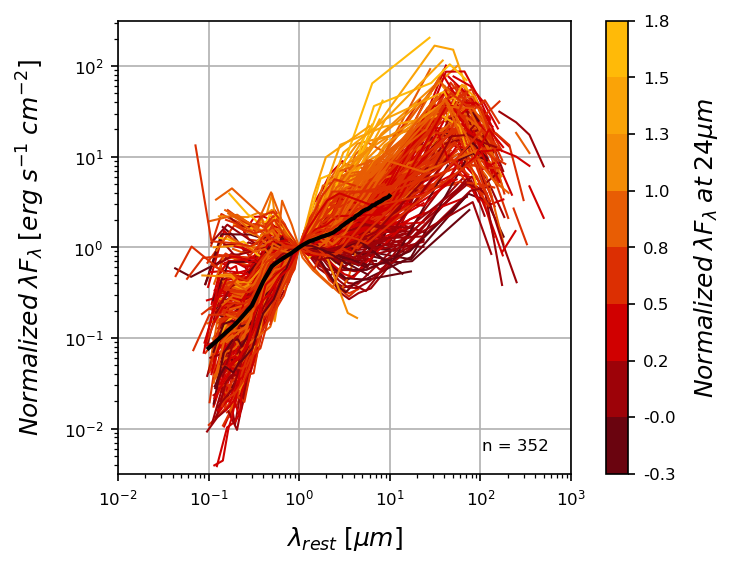

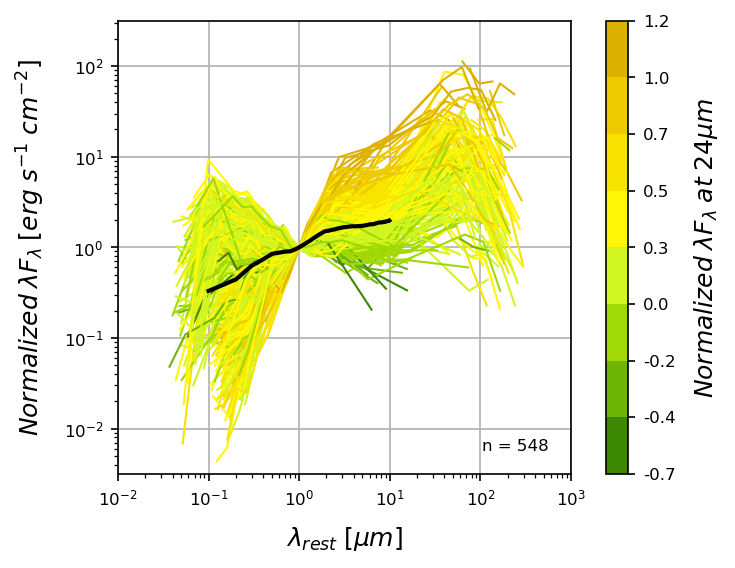

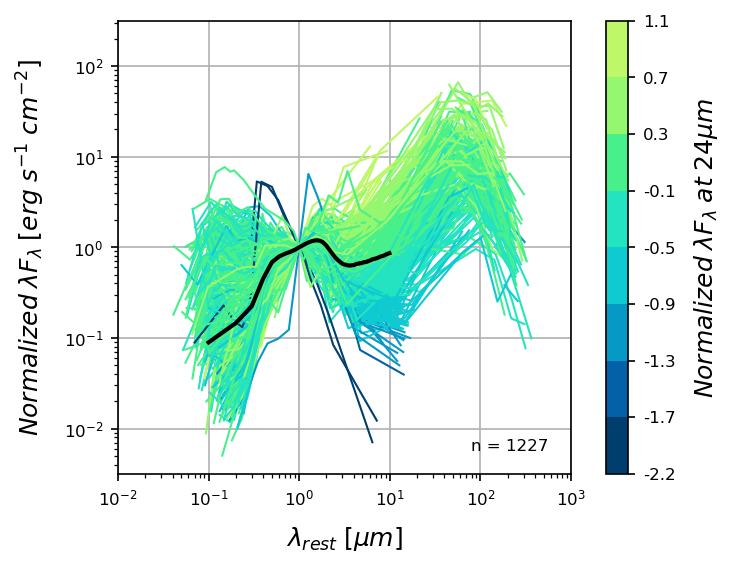

In [10]:
# plot SEDs for all color AGN 
for key,val in agnInfo.items():
    # determine key
    if(key == 'RED') : 
        SED.PlotSED(val['Rest Wavelength'],val['Normalized Energy Density'],cmap='r',save=adp.path_fig+'\\SED_red_zAll.png')
    elif(key == 'YEL') : 
        SED.PlotSED(val['Rest Wavelength'],val['Normalized Energy Density'],cmap='y',save=adp.path_fig+'\\SED_yel_zAll.png')
    elif(key == 'BLU') :
        SED.PlotSED(val['Rest Wavelength'],val['Normalized Energy Density'],cmap='b',save=adp.path_fig+'\\SED_blu_zAll.png')
    else :
        SED.PlotSED(val['Rest Wavelength'],val['Normalized Energy Density'])

In [11]:
# TODO make z<1 subsample